# Variations of Optimal Designs
Week 10, Group 2

# Introduction: Variations of Optimal Designs

Optimal designs are advanced experimental layouts that aim to extract the maximum
information from the fewest possible experiments. They are particularly useful when
traditional factorial designs are impractical due to constraints or limited resources.

Different optimality criteria define the variations of optimal designs:
- D-optimal: minimizes parameter estimation errors.
- A-optimal: minimizes average parameter variance.
- I-optimal: minimizes average prediction variance.
- G-optimal: minimizes maximum prediction variance.

In metamodelling, optimal designs help generate efficient training data for surrogate
models, reducing computational cost while preserving accuracy. Understanding these
variations is essential for building reliable and cost-effective metamodels.




#  Mathematical Background of Optimal Design Variations


In Design of Experiments (DoE), we represent the relationship between input variables (X)
and output responses (y) as a regression model:

    y = Xβ + ε

$$
  y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1^2 + \beta_4 x_2^2 + \beta_5 x_1 x_2
$$

where:
- X is the design matrix (n × p) containing experimental settings,
- β is the vector of model parameters,
- ε is random experimental noise (with variance σ²).

The precision of estimated parameters β depends on the matrix (X'X).  
Different "optimality criteria" define how to choose X so that experiments give the
most useful information for our purpose.






# 1. D-optimal Design

Objective: Maximize the determinant of the information matrix (X'X).

    max det(X'X)

- Goal: Maximize the determinant of the information matrix.
- Use case: Minimizes the volume of the confidence ellipsoid for parameter estimates.
- Best for: Linear and nonlinear regression models.
- Interpretation: Provides the most "compact" confidence region for parameters.


# 2. A-optimal Design

Objective: Minimize the average variance of parameter estimates.

    min trace((X'X)⁻¹)

- Goal: Minimize the trace of the inverse of the information matrix.
- Use case: Minimizes the average variance of the parameter estimates.
- Best for: When you care about overall precision across all parameters.


# 3. G-optimal Design

Objective: Minimize the *maximum* prediction variance among all possible design points.

    min max_x [ x'(X'X)⁻¹x ]

- Goal: Minimize the maximum prediction variance over the design space.
- Use case: Focuses on prediction accuracy rather than parameter estimation.
- Best for: Response surface modeling or when predictions are more important than parameters.

# 4. I-optimal Design

Objective: Minimize the *average prediction variance* across the entire design space.

    min ∫_D x'(X'X)⁻¹x dx

- Goal: Minimize the average prediction variance over the design space.
- Use case: Similar to G-optimal but averages prediction error instead of minimizing the worst-case.
- Best for: When you want good overall prediction performance.







Summary:

| Criterion  | Focus                        | Objective                              |
|-------------|------------------------------|----------------------------------------|
| D-optimal   | Overall precision of β       | max det(X'X)                           |
| A-optimal   | Average precision of β       | min trace((X'X)⁻¹)                     |
| I-optimal   | Average prediction accuracy  | min ∫ x'(X'X)⁻¹x dx                   |
| G-optimal   | Uniform prediction accuracy  | min max_x x'(X'X)⁻¹x                  |


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import det, pinv, inv

# Helper: information matrix with intercept
def model_matrix(X):
    x1, x2 = X[:, 0], X[:, 1]
    return np.column_stack([
        np.ones(len(X)),
        x1, x2,
        x1**2, x2**2, x1 * x2
    ])

# Helper: prediction variance
def pred_var(X_design, X_eval):
    M = model_matrix(X_design)
    XtX_inv = pinv(M.T @ M)
    H = model_matrix(X_eval)
    return np.sum(H @ XtX_inv * H, axis=1)

# D-optimal
def d_optimal_design(X_cand, n, max_iter=100):
    idx = np.random.choice(len(X_cand), n, replace=False)
    X = X_cand[idx]
    for _ in range(max_iter):
        improved = False
        for i in range(n):
            for j in range(len(X_cand)):
                X_try = X.copy()
                X_try[i] = X_cand[j]
                if det(model_matrix(X_try).T @ model_matrix(X_try)) > det(model_matrix(X).T @ model_matrix(X)):
                    X = X_try
                    improved = True
        if not improved:
            break
    return X

# A-optimal (minimize average variance)
def a_optimal_design(X_cand, n, max_iter=100):
    idx = np.random.choice(len(X_cand), n, replace=False)
    X = X_cand[idx]
    for _ in range(max_iter):
        improved = False
        for i in range(n):
            for j in range(len(X_cand)):
                X_try = X.copy()
                X_try[i] = X_cand[j]
                if np.trace(inv(model_matrix(X_try).T @ model_matrix(X_try))) < np.trace(inv(model_matrix(X).T @ model_matrix(X))):
                    X = X_try
                    improved = True
        if not improved:
            break
    return X

# G-optimal design (minimize max prediction variance)
def g_optimal_design(X_candidates, n):
    chosen = []
    for _ in range(n):
        best_idx, best_score = None, np.inf
        for i in range(len(X_candidates)):
            if i in chosen:
                continue
            X_try = X_candidates[chosen + [i]]
            try:
                var_pred = pred_var(X_try, X_candidates)
                score = np.max(var_pred)
            except np.linalg.LinAlgError:
                continue  # skip singular cases safely
            if score < best_score:
                best_score = score
                best_idx = i
        if best_idx is not None:
            chosen.append(best_idx)
        else:
            print("Warning: could not find non-singular point at this step.")
            break
    return X_candidates[chosen]


# I-optimal design (minimize average prediction variance)
def i_optimal_design(X_candidates, n):
    chosen = []
    for _ in range(n):
        best_idx, best_score = None, np.inf
        for i in range(len(X_candidates)):
            if i in chosen:
                continue
            X_try = X_candidates[chosen + [i]]
            try:
                var_pred = pred_var(X_try, X_candidates)
                score = np.mean(var_pred)
            except np.linalg.LinAlgError:
                continue # skip singular designs
            if score < best_score:
                best_score = score
                best_idx = i
        if best_idx is not None:
            chosen.append(best_idx)
        else:
            print("Warning: Could not find a non-singular point at this step.")
            break
    return X_candidates[chosen]

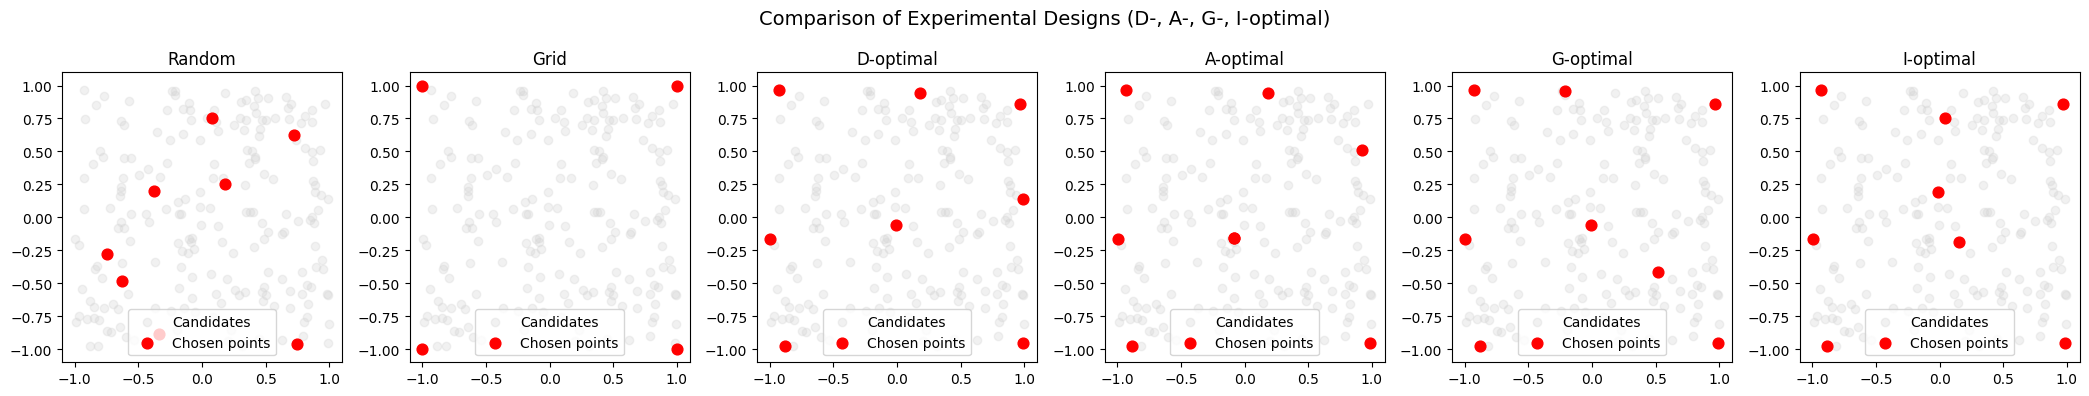

In [2]:
# Candidate space
np.random.seed(27)
n_points = 8
X_cand = np.random.uniform(-1, 1, size=(200, 2))

# Random and grid designs
X_rand = np.random.uniform(-1, 1, size=(n_points, 2))
grid = np.linspace(-1, 1, int(np.sqrt(n_points)))
X_grid = np.array(np.meshgrid(grid, grid)).T.reshape(-1, 2)

X_dopt = d_optimal_design(X_cand, n_points)
X_aopt = a_optimal_design(X_cand, n_points)
X_gopt = g_optimal_design(X_cand, n_points)
X_iopt = i_optimal_design(X_cand, n_points)

fig, axs = plt.subplots(1, 6, figsize=(21, 4))
designs = [X_rand, X_grid, X_dopt, X_aopt, X_gopt, X_iopt]
titles = ["Random", "Grid", "D-optimal", "A-optimal", "G-optimal", "I-optimal"]

for ax, X, title in zip(axs, designs, titles):
    ax.scatter(X_cand[:, 0], X_cand[:, 1], color='lightgray', alpha=0.3, label="Candidates")
    ax.scatter(X[:, 0], X[:, 1], color='red', s=60, label="Chosen points")
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_title(title)
    ax.legend()

plt.suptitle("Comparison of Experimental Designs (D-, A-, G-, I-optimal)", fontsize=14)
plt.tight_layout()
plt.show()


## Example: Comparing Optimal Experimental Designs Under Noise

### Goal
Demonstrate how different design criteria (D-, A-, G-, I-optimal) perform compared to a random design when:
- The **true model** is well-specified (quadratic in two factors).
- Observations include **Gaussian noise**.
- Designs are chosen from a fixed candidate set.

### Setup
- **Model basis**: Quadratic with intercept  
  $$
  y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1^2 + \beta_4 x_2^2 + \beta_5 x_1 x_2
  $$

- **Candidate set**: 400 points uniformly sampled in \([-1, 1]^2\) (fixed across trials).
- **Design size**: \(n = 10\) points.
- **Noise**: $\varepsilon \sim \mathcal{N}(0, \sigma^2)$, with $\sigma = 0.08$.
- **Evaluation grid**: 40×40 uniform grid over $[-1, 1]^2$.



### Metrics
For each design and trial:
- **Pred MSE**: Prediction error on the evaluation grid vs. noise-free truth.
- **β-RMSE**: Root mean squared error of estimated coefficients vs. true \(\beta\).

### Experiment
- Run **100 trials** with the same candidate set.
- Each trial introduces new random noise in observations.


In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression

np.random.seed(43)

# Define the true nonlinear function
beta_true = np.array([0.5, -0.8, 0.6, 0.9, 0.1, -0.4])
noise_sigma = 0.08

def true_func(X):
    return model_matrix(X) @ beta_true

# Candidate and evaluation grid
n_candidates = 400
X_cand = np.random.uniform(-1, 1, size=(n_candidates, 2))
n_design = 10

grid = np.linspace(-1, 1, 50)
# X_grid = np.array(np.meshgrid(grid, grid)).T.reshape(-1, 2)
X_grid = X_cand
Y_true = true_func(X_grid)

# Generate designs
X_rand = np.random.uniform(-1, 1, size=(n_design, 2))
X_dopt = d_optimal_design(X_cand, n_design)
X_aopt = a_optimal_design(X_cand, n_design)
X_gopt = g_optimal_design(X_cand, n_design)
X_iopt = i_optimal_design(X_cand, n_design)

designs = {
    "Random": X_rand,
    "D-Optimal": X_dopt,
    "A-Optimal": X_aopt,
    "G-Optimal": X_gopt,
    "I-Optimal": X_iopt
}

# Simulate experiments and fit model
n_runs = 100
results = {}
for name, X in designs.items():
    np.random.seed(43)
    results[name]={"model": [], "y_pred": [], "Pred MSE": [], "Beta RMSE": []}
    for i in range(n_runs):
        y_true = true_func(X)
        y_obs = y_true + np.random.normal(0, noise_sigma, size=len(y_true))
        model = LinearRegression().fit(model_matrix(X), y_obs)
        beta_hat = model.coef_
        y_pred = model.predict(model_matrix(X_grid))
        results[name]["model"].append(model)
        results[name]["y_pred"].append(y_pred)
        results[name]["Pred MSE"].append(np.mean((y_pred - Y_true)**2))
        results[name]["Beta RMSE"].append(float(np.sqrt(np.mean((beta_hat - beta_true)**2))))

pred_res = {}
beta_res = {}
for key, value in results.items():
    pred_res[key] = value["Pred MSE"]
    beta_res[key] = value["Beta RMSE"]

pred_res_df = pd.DataFrame(pred_res)
beta_res_df = pd.DataFrame(beta_res)

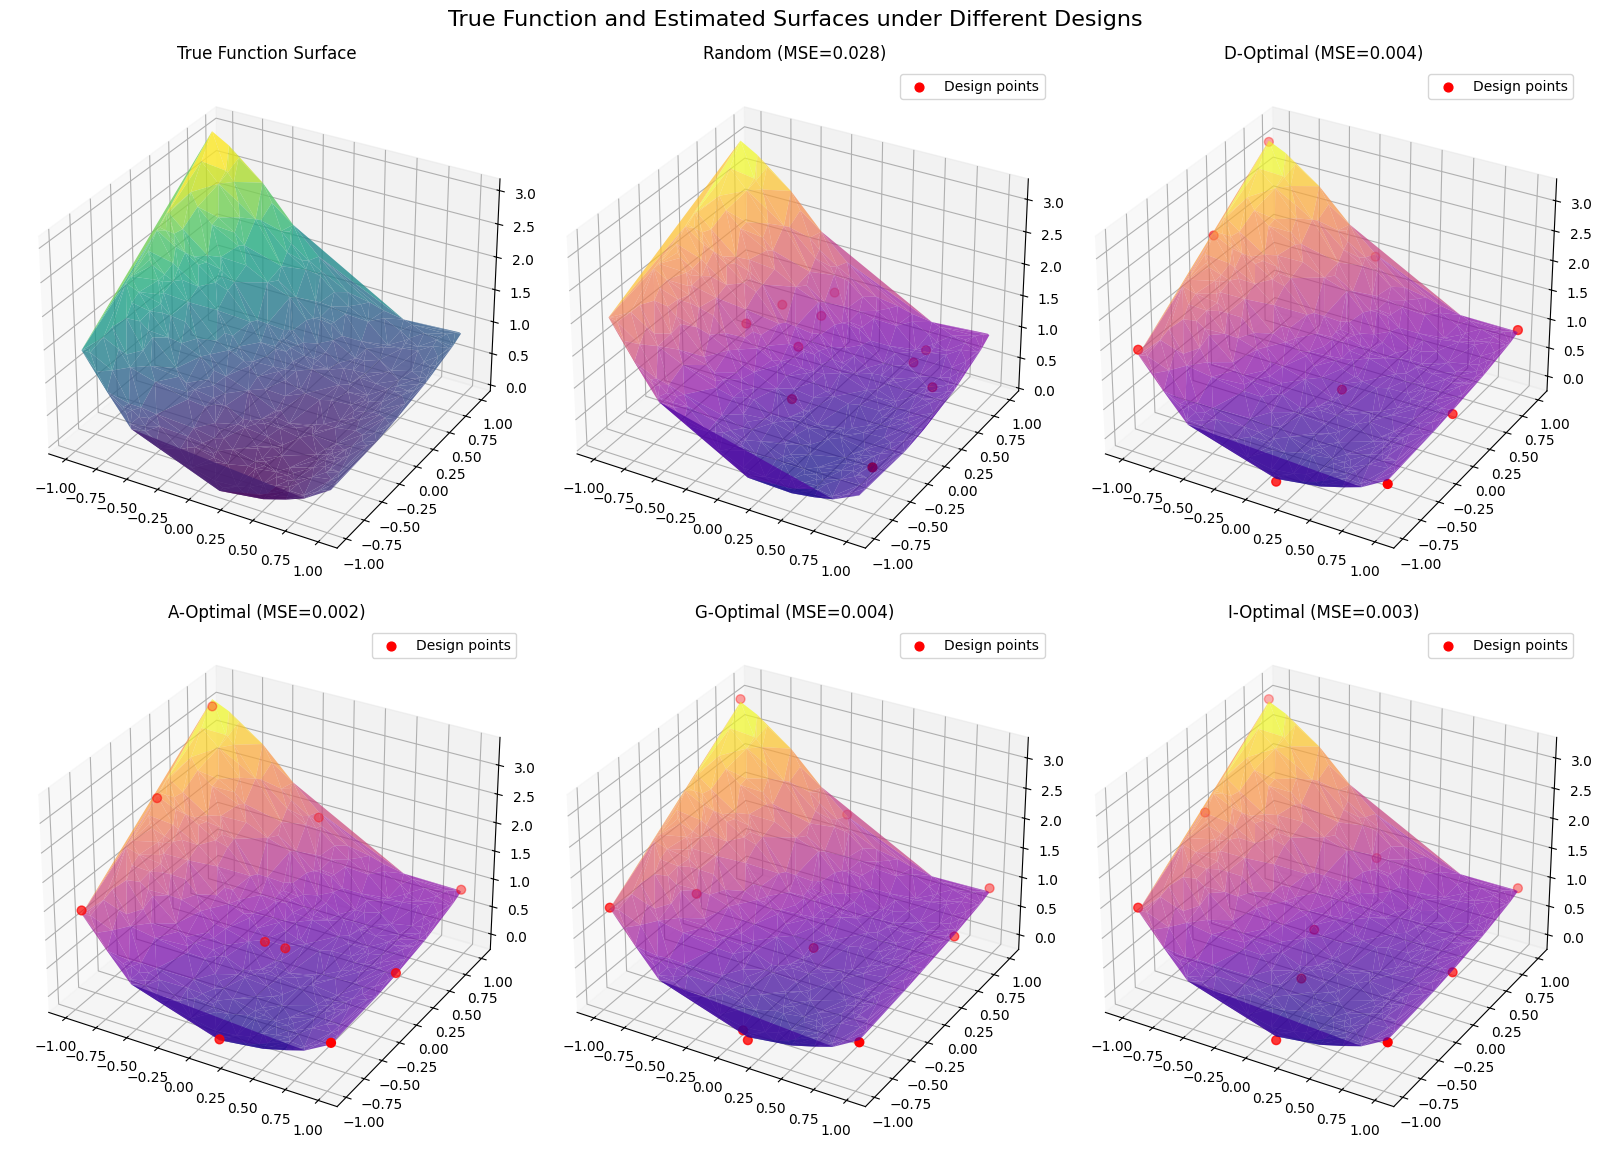

In [4]:
fig = plt.figure(figsize=(16, 12))

# Plot true function once
ax_true = fig.add_subplot(2, 3, 1, projection='3d')
ax_true.plot_trisurf(X_grid[:, 0], X_grid[:, 1], Y_true, cmap='viridis', alpha=0.8)
ax_true.set_title("True Function Surface")

# Plot estimated surfaces for each design
plot_idx = 2
for name, X in designs.items():
    y_pred = results[name]["y_pred"][0]
    mse = results[name]["Pred MSE"][0]

    ax = fig.add_subplot(2, 3, plot_idx, projection='3d')
    ax.plot_trisurf(X_grid[:, 0], X_grid[:, 1], y_pred, cmap='plasma', alpha=0.7)
    ax.scatter(X[:, 0], X[:, 1], true_func(X), color='red', s=40, label='Design points')
    ax.set_title(f"{name} (MSE={mse:.3f})")
    ax.legend()
    plot_idx += 1

plt.suptitle("True Function and Estimated Surfaces under Different Designs", fontsize=16)
plt.tight_layout()
plt.show()


In [5]:
for name, res in sorted(results.items(), key=lambda kv: np.array(kv[1]['Pred MSE']).mean()):
    print(f"{name:7s} | Pred MSE={pred_res_df[name].mean():.5f}+-{pred_res_df[name].std():.5f} | Beta RMSE={beta_res_df[name].mean():.4f}+-{beta_res_df[name].std():.4f}")


A-Optimal | Pred MSE=0.00231+-0.00147 | Beta RMSE=0.2086+-0.0032
I-Optimal | Pred MSE=0.00256+-0.00189 | Beta RMSE=0.2089+-0.0034
D-Optimal | Pred MSE=0.00275+-0.00225 | Beta RMSE=0.2084+-0.0028
G-Optimal | Pred MSE=0.00291+-0.00208 | Beta RMSE=0.2092+-0.0041
Random  | Pred MSE=0.04489+-0.05550 | Beta RMSE=0.2773+-0.0642



## Conclusion
- All optimal designs outperformed random sampling, confirming that systematic point selection improves model accuracy.

- **Prediction accuracy (Pred MSE)**  
   - **A‑optimal** shows the lowest mean Grid MSE in this run, with **I‑optimal** a close second
   - Might have expected I to be better?
   - But they are all very close

- **Parameter accuracy (β‑RMSE)**  
   - **D‑optimal** is best (A‑optimal extremely close).
   - This reflects their objectives
   - But they are all very close



- **Variability**  
   - Random exhibits very high variability (std comparable to or exceeding its mean).
   - Optimal designs are much more stable.
   
Overall:
→ A- and D-optimal designs are the most reliable choices for small,
   polynomial-based metamodelling tasks.
→ Optimal design selection should align with the modelling goal:
   parameter precision (A/D) vs prediction uniformity (G/I).


**Recommendations**
- If the **goal is inference** (accurate coefficients), choose **D‑ or A‑optimal**.  
- If the **goal is prediction** over a region, choose **I‑optimal** (or **G‑optimal**)—here, I and A are statistically close on Grid MSE.  